In [2]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.decoding import Scaler
import pickle
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [6]:
def calc_power(xdata,exp,lower=None,upper=None,lower_upper_list=None):
    info = mne.create_info(list(exp.info['electrode_labels']),int(exp.info['sampling_rate']),'eeg')
    eeg = mne.EpochsArray(xdata,info=info,verbose=False)
    if lower_upper_list:
        for bands in lower_upper_list:
            copy_eeg = eeg.copy()
            copy_eeg.filter(bands[0],bands[1],n_jobs=1,l_trans_bandwidth=1,h_trans_bandwidth=1,verbose=False)
            copy_eeg.apply_hilbert(envelope=True,verbose=False)
            xdata = np.concatenate((xdata,copy_eeg.get_data()),1)
    else:
        eeg.filter(lower,upper,n_jobs=1,l_trans_bandwidth=1,h_trans_bandwidth=1,verbose=False)
        eeg.apply_hilbert(envelope=True,verbose=False)
        xdata = eeg.get_data()
    return xdata

def average_times(xdata,num_t):
    X_test_timepoints = np.zeros((xdata.shape[0],xdata.shape[1],num_t))
    for X_test in ltm_wrangl.roll_over_time(xdata):
        X_test_timepoints[:,:,ltm_wrangl.itime] = X_test
    return X_test_timepoints

# ERPs

## WM

In [75]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')
erp = decode_eeg.ERP(exp)

xdata_all, ydata_all = erp.load_all_eeg(xdata_var_name = 'wm_xdata', ydata_var_name = 'wm_ydata',start_epoch=-200,end_epoch=850)

In [38]:
# xdata_all = np.empty((exp.nsub),dtype='object')
# ydata_all = np.empty((exp.nsub),dtype='object')
# for isub in range(exp.nsub):
#      xdata,ydata= exp.load_eeg(isub, xdata_var_name='wm_xdata',ydata_var_name='wm_ydata',start_epoch=-200,end_epoch=1000)
#      xdata = scaler.fit_transform(xdata)
#      xdata_all[isub], ydata_all[isub] = xdata, ydata

Saving output\figures\20201130_184758.png


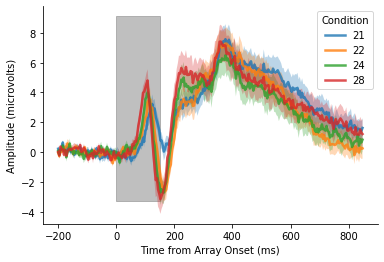

In [86]:
erp.plot_conditions(xdata_all,ydata_all,electrode_subset = ('O','P'),conditions = [21,22,24,28],savefig=True)

## LTM

In [17]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='ltm')
erp = decode_eeg.ERP(exp)

xdata_all, ydata_all = erp.load_all_eeg(xdata_var_name = 'ltm_xdata', ydata_var_name = 'ltm_ydata',start_epoch=-200,end_epoch=2350)
for isub in range(exp.nsub):
    xdata_all[isub] = xdata_all[isub][1:]

Saving output\figures\20201130_185152.png


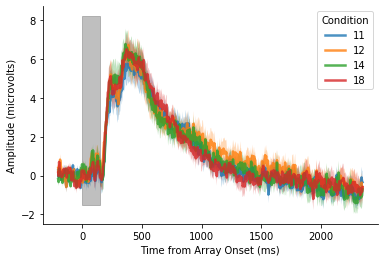

In [89]:
erp.plot_conditions(xdata_all,ydata_all,electrode_subset = ('O','P'), conditions = [11,12,14,18],savefig=True)

# WM Classification with Raw EEG

In [15]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')

time_window = 30
time_step = 30
trial_average = 10
n_splits = 30
group_dict = {0:[21],1:[22],2:[24],3:[28]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=4)

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub,xdata_var_name='wm_xdata',ydata_var_name='wm_ydata')
    xdata,ydata = wrangl.setup_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,isub)
interp = decode_eeg.Interpreter(clfr)
interp.plot_acc(significance_testing=1,savefig=1,ylim=[.18,.6])
interp.plot_conf_mat(lower=.0,upper=.5,savefig=0)

# Alpha Power ERPs

In [6]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')
erp = decode_eeg.ERP(exp)

xdata_all = np.empty((exp.nsub),dtype='object')
ydata_all = np.empty((exp.nsub),dtype='object')
for isub in range(exp.nsub):
     xdata,ydata= exp.load_eeg(isub, xdata_var_name='wm_xdata',ydata_var_name='wm_ydata')
     xdata = calc_power(xdata,exp,8,13)
     xdata = exp.trim_epochs(xdata,start=-200,end=1000)
     xdata_all[isub], ydata_all[isub] = xdata, ydata

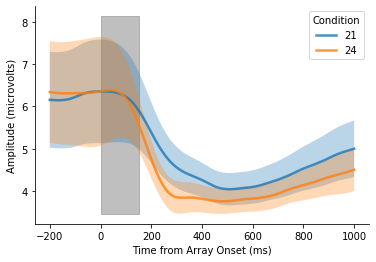

In [25]:
erp.plot_conditions(xdata_all,ydata_all,electrode_subset = ('O'),conditions = [21,24])

# WM Classification with Alpha

In [4]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')

time_window = 30
time_step = 30
trial_average = 10
n_splits = 30
group_dict = {0:[21],1:[22],2:[24],3:[28]}

wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)
clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=4)

In [159]:
for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub,xdata_var_name='wm_xdata',ydata_var_name='wm_ydata')
    xdata = calc_power(xdata,exp,lower=8,upper=12)
    xdata = exp.trim_epochs(-200,1000,xdata)
    xdata,ydata = wrangl.setup_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [160]:
interp = decode_eeg.Interpreter(clfr)

Saving output\figures\acc20201115_2355.pdf
Saving output\figures\acc20201115_2355.png


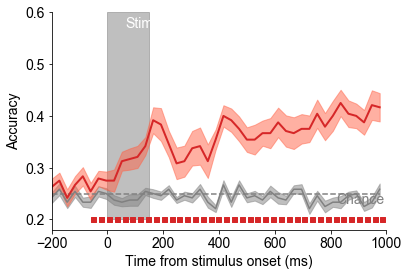

In [162]:
interp.plot_acc(significance_testing=1,savefig=1,ylim=[.18,.6])

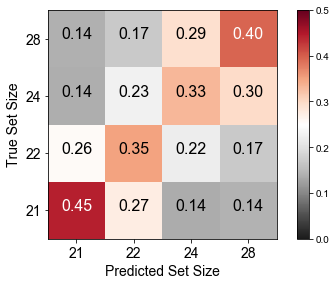

In [163]:
interp.plot_conf_mat(lower=.0,upper=.5,savefig=0)

# LTM Classification with Raw EEG

In [146]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='ltm')
exp.trim_epochs(-200,2350)

time_window = 30
time_step = 30
trial_average = 10
n_splits = 30
group_dict = {0:[11],1:[12],2:[14],3:[18]}

wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)
clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=4)

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub,xdata_var_name='ltm_xdata',ydata_var_name='ltm_ydata',start_epoch=-200,end_epoch=2350)
    xdata = xdata[1:] #accidently output 1 extra trial of WM task at beginning
    xdata,ydata = wrangl.setup_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Saving output\figures\acc20201117_1943.pdf
Saving output\figures\acc20201117_1943.png


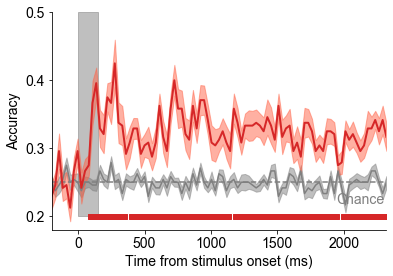

Saving output\figures\conf_mat20201117_1943.pdf
Saving output\figures\conf_mat20201117_1943.png


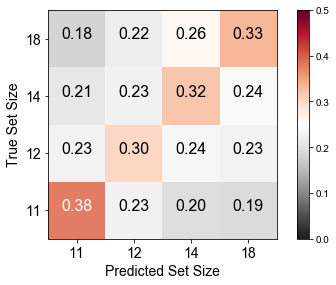

In [150]:
interp = decode_eeg.Interpreter(clfr)
interp.plot_acc(significance_testing=1,savefig=1,ylim=[.18,.5])
interp.plot_conf_mat(lower=.0,upper=.5,savefig=1)

# LTM Classification with Alpha

In [159]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='ltm')
exp.trim_epochs(-200,2350)

time_window = 30
time_step = 30
trial_average = 10
n_splits = 30
group_dict = {0:[11],1:[12],2:[14],3:[18]}

wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)
clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=4)

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub,xdata_var_name='ltm_xdata',ydata_var_name='ltm_ydata')
    xdata = xdata[1:] #accidently output 1 extra trial of WM task at beginning
    xdata = calc_power(xdata,exp,lower=8,upper=12)
    xdata = exp.trim_epochs(-200,2350,xdata)
    xdata,ydata = wrangl.setup_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Saving output\figures\acc20201117_2001.pdf
Saving output\figures\acc20201117_2001.png


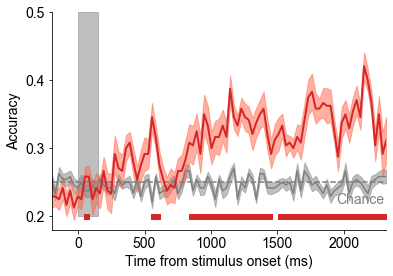

Saving output\figures\conf_mat20201117_2001.pdf
Saving output\figures\conf_mat20201117_2001.png


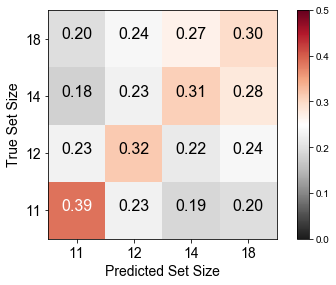

In [161]:
interp = decode_eeg.Interpreter(clfr)
interp.plot_acc(significance_testing=1,savefig=1,ylim=[.18,.5])
interp.plot_conf_mat(lower=.0,upper=.5,savefig=1)

# LTM Classification from WM with Raw EEG

### Train WM models

In [8]:
from copy import copy
data_dir = './data'
time_window = 20
time_step = 20
trial_average = 10
n_splits = 1
group_dict = {0:[21],1:[22],2:[24],3:[28]}

wm_exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')
wm_exp.trim_epochs(-200,1000)
wm_wrangl = decode_eeg.Wrangler(wm_exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

scaler = Scaler(scalings='mean')
clfr = decode_eeg.Classification(wm_wrangl,wm_exp.nsub)

In [9]:
scalers = np.empty(wm_exp.nsub,dtype='object')
classifiers = np.empty((wm_exp.nsub,np.size(wm_wrangl.t)),dtype='object')
for isub in range(wm_exp.nsub):
    print(isub)
    xdata,ydata = wm_exp.load_eeg(isub,xdata_var_name='wm_xdata',ydata_var_name='wm_ydata',start_epoch=-200,end_epoch=1000)
    # xdata = scaler.fit_transform(xdata)
    # scalers[isub] = copy(scaler)
    xdata,ydata = wm_wrangl.setup_data(xdata,ydata)
    for X_train in wm_wrangl.roll_over_time(xdata):
        clfr.classifier.fit(X_train, ydata)
        classifiers[isub,wm_wrangl.itime] = copy(clfr.classifier)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


### Test on LTM

In [6]:
def average_times(xdata,num_t):
    X_test_timepoints = np.zeros((xdata.shape[0],xdata.shape[1],num_t))
    for X_test in ltm_wrangl.roll_over_time(xdata):
        X_test_timepoints[:,:,ltm_wrangl.itime] = X_test
    return X_test_timepoints

In [14]:
data_dir = './data'
time_window = 20
time_step = 20
trial_average = 10
n_splits = 10
group_dict = {0:[11],1:[12],2:[14],3:[18]}

ltm_exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='ltm')
ltm_exp.trim_epochs(-200,2350)
ltm_wrangl = decode_eeg.Wrangler(ltm_exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

acc = np.empty((ltm_exp.nsub,n_splits,len(ltm_wrangl.t),len(wm_wrangl.t)))
acc_shuff = np.empty((ltm_exp.nsub,n_splits,len(ltm_wrangl.t),len(wm_wrangl.t)))

In [15]:
for isub in range(ltm_exp.nsub):
    print(isub)
    xdata,ydata = ltm_exp.load_eeg(isub,xdata_var_name='ltm_xdata',ydata_var_name='ltm_ydata',start_epoch=-200,end_epoch=2350)
    xdata = xdata[1:] #accidently output 1 extra trial of WM task at beginning
    # xdata = scalers[isub].transform(xdata)
    xdata,ydata = ltm_wrangl.setup_data(xdata,ydata)
    xdata = average_times(xdata,np.size(ltm_wrangl.t))

    for X_test_all, _, y_test, _ in ltm_wrangl.train_test_split(xdata,ydata): 
        for iltm_time in range(len(ltm_wrangl.t)):
            # grab correct time from ltm trial to test
            X_test = X_test_all[:,:,iltm_time]
            for iwm_time in range(len(wm_wrangl.t)):
                # grab wm trained classifier
                classifier = classifiers[isub][iwm_time]
                #measure accuracy of predictions
                acc[isub,ltm_wrangl.ifold,iltm_time,iwm_time] = classifier.score(X_test,y_test)
                acc_shuff[isub,ltm_wrangl.ifold,iltm_time,iwm_time] = classifier.score(X_test,np.random.permutation(y_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Text(0.5, 1.0, 'WM decoding set size 1 & 4 on repeat trials\n generalizes to LTM task')

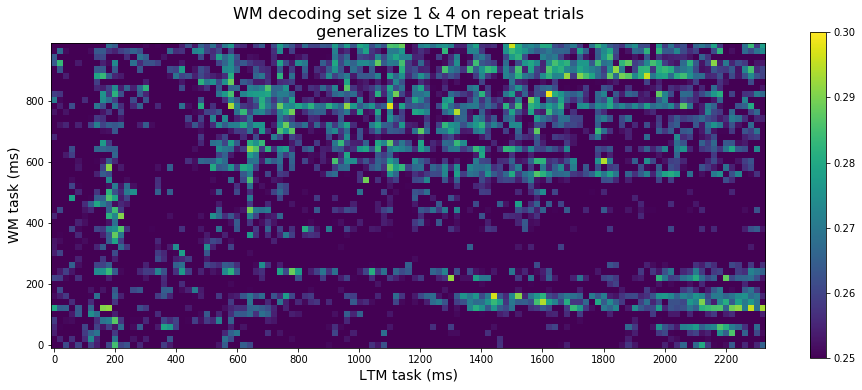

In [18]:
mean_acc = np.mean(np.mean(acc,0),0).T
plt.subplots(figsize=(16,6))
plt.imshow(mean_acc,vmin=.25,vmax=.3,interpolation='None')
plt.gca().invert_yaxis()
x = 10
plt.xticks(range(len(ltm_wrangl.t))[::x],ltm_wrangl.t[::x])
plt.xlabel('LTM task (ms)',fontsize=14)
plt.yticks(range(len(wm_wrangl.t))[::x],wm_wrangl.t[::x])
plt.ylabel('WM task (ms)',fontsize=14)
plt.colorbar();
plt.title('WM decoding set size 1 & 4 on repeat trials\n generalizes to LTM task',fontsize=16)
# plt.savefig('repeat_trial_wm_to_ltm_14.png',dpi=500)

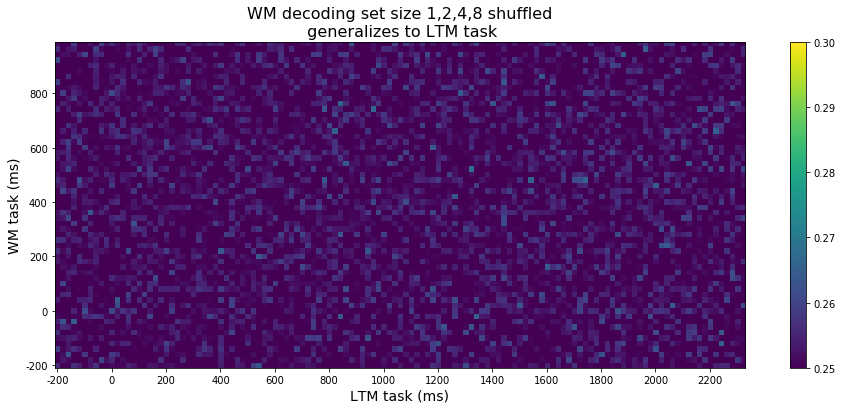

In [16]:
mean_acc = np.mean(np.mean(acc_shuff,0),0).T
plt.subplots(figsize=(16,6))
plt.imshow(mean_acc,vmin=.25,vmax=.3,interpolation='None')
plt.gca().invert_yaxis()
x = 10
plt.xticks(range(len(ltm_wrangl.t))[::x],ltm_wrangl.t[::x])
plt.xlabel('LTM task (ms)',fontsize=14)
plt.yticks(range(len(wm_wrangl.t))[::x],wm_wrangl.t[::x])
plt.ylabel('WM task (ms)',fontsize=14)
plt.colorbar();
plt.title('WM decoding set size 1,2,4,8 shuffled\n generalizes to LTM task',fontsize=16)
plt.savefig('accshuff_trial_wm_to_ltm_14.png',dpi=500)

# LTM Classification from WM with Alpha Power

### Training WM models

In [38]:
from copy import copy
data_dir = './data'
time_window = 20
time_step = 20
trial_average = 10
n_splits = 1
group_dict = {0:[21],1:[24]}

wm_exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')
wm_exp.trim_epochs(-200,1000)
wm_wrangl = decode_eeg.Wrangler(wm_exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

scaler = Scaler(scalings='mean')
clfr = decode_eeg.Classification(wm_wrangl,wm_exp.nsub,num_labels=3)

In [52]:
scalers = np.empty(wm_exp.nsub,dtype='object')
classifiers = np.empty((wm_exp.nsub,np.size(wm_wrangl.t)),dtype='object')
for isub in range(wm_exp.nsub):
    print(isub)
    xdata,ydata = wm_exp.load_eeg(isub,xdata_var_name='wm_xdata',ydata_var_name='wm_ydata')
    xdata = calc_power(xdata,wm_exp,lower=12,upper=20)
    xdata = wm_exp.trim_epochs(-200,1000,xdata)
    # xdata = scaler.fit_transform(xdata)
    # scalers[isub] = copy(scaler)
    xdata,ydata = wm_wrangl.setup_data(xdata,ydata)
    for X_train in wm_wrangl.roll_over_time(xdata):
        clfr.classifier.fit(X_train, ydata)
        classifiers[isub,wm_wrangl.itime] = copy(clfr.classifier)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


## Testing on LTM Data

In [44]:
data_dir = './data'
time_window = 20
time_step = 20
trial_average = 10
n_splits = 3
group_dict = {0:[11],1:[14]}

ltm_exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='ltm')
ltm_exp.trim_epochs(-200,2350)
ltm_wrangl = decode_eeg.Wrangler(ltm_exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

acc = np.empty((ltm_exp.nsub,n_splits,len(ltm_wrangl.t),len(wm_wrangl.t)))
acc_shuff = np.empty((ltm_exp.nsub,n_splits,len(ltm_wrangl.t),len(wm_wrangl.t)))

In [53]:
for isub in range(ltm_exp.nsub):
    print(isub)
    xdata,ydata = ltm_exp.load_eeg(isub,xdata_var_name='ltm_xdata',ydata_var_name='ltm_ydata')
    xdata = xdata[1:] #accidently output 1 extra trial of WM task at beginning
    xdata = calc_power(xdata,ltm_exp,lower=12,upper=20)
    xdata = ltm_exp.trim_epochs(-200,2350,xdata)
    # xdata = scalers[isub].transform(xdata)
    xdata,ydata = ltm_wrangl.setup_data(xdata,ydata)
    xdata = average_times(xdata,np.size(ltm_wrangl.t))

    for X_test_all, _, y_test, _ in ltm_wrangl.train_test_split(xdata,ydata): 
        for iltm_time in range(len(ltm_wrangl.t)):
            # grab correct time from ltm trial to test
            X_test = X_test_all[:,:,iltm_time]
            for iwm_time in range(len(wm_wrangl.t)):
                # grab wm trained classifier
                classifier = classifiers[isub][iwm_time]
                #measure accuracy of predictions
                acc[isub,ltm_wrangl.ifold,iltm_time,iwm_time] = classifier.score(X_test,y_test)
                acc_shuff[isub,ltm_wrangl.ifold,iltm_time,iwm_time] = classifier.score(X_test,np.random.permutation(y_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Text(0.5, 1.0, 'WM decoding set size 1 & 4 with 12-20\n generalizes to LTM task')

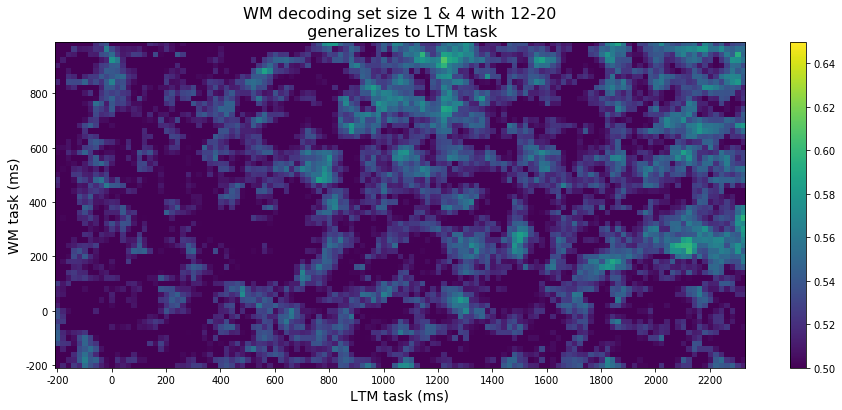

In [54]:
mean_acc = np.mean(np.mean(acc,0),0).T
plt.subplots(figsize=(16,6))
plt.imshow(mean_acc,vmin=.5,vmax=.65,interpolation='None')
plt.gca().invert_yaxis()
x = 10
plt.xticks(range(len(ltm_wrangl.t))[::x],ltm_wrangl.t[::x])
plt.xlabel('LTM task (ms)',fontsize=14)
plt.yticks(range(len(wm_wrangl.t))[::x],wm_wrangl.t[::x])
plt.ylabel('WM task (ms)',fontsize=14)
plt.colorbar();
plt.title('WM decoding set size 1 & 4 with 12-20\n generalizes to LTM task',fontsize=16)
# plt.savefig('wm_to_ltm_14_alpha.png',dpi=500)

# Trained on Archery, test on F&W

In [33]:
import pickle
# load the model from disk
filename = 'models.sav'
models = pickle.load(open(filename, 'rb'))

In [34]:
remove_index = np.array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False,  True,  True,
        True])

In [13]:
data_dir = './data'
time_window = 20
time_step = 20
trial_average = 10
n_splits = 10
group_dict = {0:[11],1:[12],2:[14],3:[18]}

ltm_exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='ltm')
ltm_exp.trim_epochs(-200,2350)
ltm_wrangl = decode_eeg.Wrangler(ltm_exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)


In [16]:
acc = np.empty((ltm_exp.nsub,n_splits,len(ltm_wrangl.t),len(models)))
acc_shuff = np.empty((ltm_exp.nsub,n_splits,len(ltm_wrangl.t),len(models)))

for isub in range(ltm_exp.nsub):
    print(isub)
    xdata,ydata = ltm_exp.load_eeg(isub,xdata_var_name='ltm_xdata',ydata_var_name='ltm_ydata',start_epoch=-200,end_epoch=2350)
    xdata = xdata[1:] #accidently output 1 extra trial of WM task at beginning
    # xdata = scalers[isub].transform(xdata)
    xdata,ydata = ltm_wrangl.setup_data(xdata,ydata)
    xdata = average_times(xdata,np.size(ltm_wrangl.t))

    for X_test_all, _, y_test, _ in ltm_wrangl.train_test_split(xdata,ydata): 
        for iltm_time in range(len(ltm_wrangl.t)):
            # grab correct time from ltm trial to test
            X_test = X_test_all[:,:,iltm_time]
            for iwm_time in range(len(models)):
                # grab wm trained classifier
                classifier = models[iwm_time]
                #measure accuracy of predictions
                acc[isub,ltm_wrangl.ifold,iltm_time,iwm_time] = classifier.score(X_test,y_test)
                acc_shuff[isub,ltm_wrangl.ifold,iltm_time,iwm_time] = classifier.score(X_test,np.random.permutation(y_test))


0


ValueError: X has 19 features per sample; expecting 30

In [ ]:

mean_acc = np.mean(np.mean(acc,0),0).T
plt.subplots(figsize=(16,6))
plt.imshow(mean_acc,vmin=.25,vmax=.3,interpolation='None')
plt.gca().invert_yaxis()
x = 10
plt.xticks(range(len(ltm_wrangl.t))[::x],ltm_wrangl.t[::x])
plt.xlabel('LTM task (ms)',fontsize=14)
plt.yticks(range(len(wm_wrangl.t))[::x],wm_wrangl.t[::x])
plt.ylabel('WM task (ms)',fontsize=14)
plt.colorbar();
plt.title('WM decoding set size 1 & 4 on repeat trials\n generalizes to LTM task',fontsize=16)
# plt.savefig('repeat_trial_wm_to_ltm_14.png',dpi=500)

## WM classification, trained on Archery

In [62]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')
exp.trim_epochs(-200,1250)

time_window = 25
time_step = 25
trial_average = 10
n_splits = 1000
group_dict = {0:[21],1:[24]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=2)

In [63]:
acc = np.zeros((clfr.nsub,np.size(clfr.t),wrangl.n_splits))*np.nan
acc_shuff = np.zeros((clfr.nsub,np.size(clfr.t),wrangl.n_splits))*np.nan

for isub in range(exp.nsub):
    
    print(isub)
    xdata,ydata = exp.load_eeg(isub,xdata_var_name='wm_xdata',ydata_var_name='wm_ydata',start_epoch=-200,end_epoch=1250)
    xdata,ydata = wrangl.setup_data(xdata,ydata)
    xdata = xdata[:,remove_index]

    for _, X_test_all, _, y_test in wrangl.train_test_split(xdata,ydata):
        for X_test in wrangl.roll_over_time(X_test_all):
            acc[isub,wrangl.itime,wrangl.ifold,] = models[wrangl.itime].score(X_test,y_test)
            acc_shuff[isub,wrangl.itime,wrangl.ifold,] = models[wrangl.itime].score(X_test,np.random.permutation(y_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [70]:
interp = decode_eeg.Interpreter(clfr)
tindex = interp.t<1000
interp.t = interp.t[tindex]
interp.acc = acc[:,tindex]
interp.acc_shuff = acc_shuff[:,tindex]

Saving output\figures\acc20210107_1639.pdf
Saving output\figures\acc20210107_1639.png


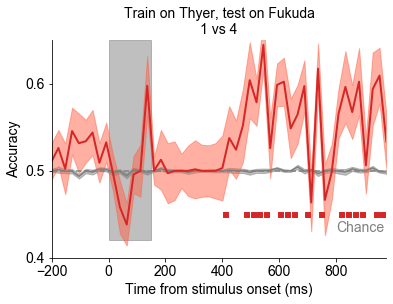

In [76]:
interp.plot_acc(significance_testing=1,savefig=True,ylim=[.4,.65],title='Train on Thyer, test on Fukuda\n1 vs 4')

## Old

In [37]:
data_dir = './data'
time_window = 30
time_step = 30
trial_average = 10
n_splits = 3
group_dict = {0:[11],1:[12],2:[14],3:[18]}

ltm_exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='ltm')
ltm_wrangl = decode_eeg.Wrangler(ltm_exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

In [127]:
acc = np.empty((ltm_exp.nsub,n_splits,len(ltm_wrangl.t)-len(wm_wrangl.t),len(wm_wrangl.t)))
acc_shuff = np.empty((ltm_exp.nsub,n_splits,len(ltm_wrangl.t),len(wm_wrangl.t)))

for isub in range(ltm_exp.nsub):
    print(isub)
    xdata,ydata = ltm_exp.load_eeg(isub,xdata_var_name='ltm_xdata',ydata_var_name='ltm_ydata')
    xdata = xdata[1:] #accidently output 1 extra trial of WM task at beginning
    xdata = scalers[isub].transform(xdata)
    xdata,ydata = ltm_wrangl.setup_data(xdata,ydata)
    xdata = average_times(xdata,np.size(ltm_wrangl.t))
    
    # grab random 80% of ltm data for testing
    for X_test_all, _, y_test, _ in ltm_wrangl.train_test_split(xdata,ydata): 
        # slide start of testing window along ltm trial times
        for iltm_start in range(len(ltm_wrangl.t)-len(wm_wrangl.t)):
            # create end of window
            iltm_end = iltm_start+len(wm_wrangl.t)
            # stop once window reaches end of trial
            # if iltm_end >= len(ltm_wrangl.t): break
            
            # slide along within the window 
            for iwm_time,iltm_time in enumerate(np.arange(iltm_start,iltm_end)):
                # grab correct time from ltm trial to test
                X_test = X_test_all[:,:,iltm_time]
                # grab wm trained classifier
                classifier = classifiers[isub][iwm_time]
                #measure accuracy of predictions
                acc[isub,ltm_wrangl.ifold,iltm_start,iwm_time] = classifier.score(X_test,y_test)
                acc_shuff[isub,ltm_wrangl.ifold,iltm_start,iwm_time] = classifier.score(X_test,np.random.permutation(y_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
